In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

In [33]:
# Generates an Array of Data obtained from ... by going through each file in both the folders Positive and Negative
def GenerateData(PATH):
    labels = ['Negative', 'Positive']
    # img = np.empty((0, 120, 120), dtype=np.float32)
    # target = np.empty((0,), dtype=np.float32)
    img = []
    target = []
    for label in labels:
        ClassPATH = os.path.join(PATH, label)
        # Category is kept as Float as CNNs doesn't take int as Target
        if label == 'Negative':
            category = 0.0
        else:
            category = 1.0
        for filename in os.listdir(ClassPATH):
            try :
                arr = cv2.imread(os.path.join(ClassPATH, filename), cv2.IMREAD_GRAYSCALE)
                # arr = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
                arr = cv2.resize(arr, (120, 120))
                arr = arr/255
                # np.vstack() is rather than np.append() as it's efficient
                # img = np.vstack((img, arr[np.newaxis, :, :]))
                # target = np.append(target, category)
                img.append(arr)
                target.append(category)
            except Exception as e:
                print(e)
    return img, target

img, target = GenerateData('DataSet')

In [34]:
# The Data Generated is Converted to Tensor and Stored as DataSet.pt in order to avoid the Data Generation Everytime
N = len(img)
a, b = img[0].shape
# Creating an empty Tensor
ImgTensor = torch.zeros(size=(N, 1, a, b))
TargetTensor = torch.zeros(N)
for i in range(N) :
    ImgTensor[i, 0, :, :] = torch.from_numpy(img[i])
    TargetTensor[i] = target[i]
DataSet = TensorDataset(ImgTensor, TargetTensor)
torch.save(DataSet, 'DataSet.pt')

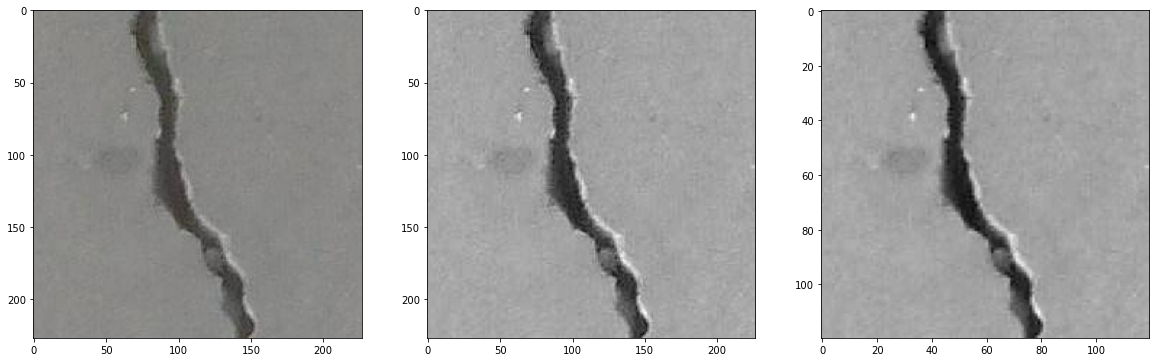

In [27]:
# Visualizing an Sample Image
SampleImg = cv2.imread('DataSet/Positive/00001.jpg')
SampleGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
SampleFinal = cv2.resize(SampleGray, (120, 120))
SampleFinal = SampleFinal/255
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(SampleImg)
plt.subplot(1, 3, 2)
plt.imshow(SampleGray, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(SampleFinal, cmap='gray')
plt.show()

In [36]:
DataSet = torch.load('DataSet.pt')
dataloader = DataLoader(DataSet, batch_size=64, shuffle=True)

In [58]:
# Defining the Architecture for the CNN Classifier
class VGG8(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG8, self).__init__()

        self.ConvLayer = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
            # nn.Conv2d(128, 128, 3, 1, 1),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(2),
            # nn.Conv2d(128, 256, 3, 1, 1),
            # nn.ReLU(inplace=True),
            # nn.Conv2d(256, 256, 3, 1, 1),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(2),
            # nn.Conv2d(256, 512, 3, 1, 1),
            # nn.ReLU(inplace=True),
            # nn.Conv2d(512, 512, 3, 1, 1),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((15, 15))

        self.FCLayer = nn.Sequential(
            nn.Linear(128 * 15 * 15, 516),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(516, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, 2),
            nn.Softmax(1)
        )

    def forward(self, x):
        x = self.ConvLayer(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.FCLayer(x)
        return x

In [59]:
# Visualizing the CNN Architecture
# device = torch.device("mps")
model = VGG8()
summary(model, (1, 120, 120))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 120, 120]             640
              ReLU-2         [-1, 64, 120, 120]               0
         MaxPool2d-3           [-1, 64, 60, 60]               0
            Conv2d-4           [-1, 64, 60, 60]          36,928
              ReLU-5           [-1, 64, 60, 60]               0
         MaxPool2d-6           [-1, 64, 30, 30]               0
            Conv2d-7          [-1, 128, 30, 30]          73,856
              ReLU-8          [-1, 128, 30, 30]               0
         MaxPool2d-9          [-1, 128, 15, 15]               0
AdaptiveAvgPool2d-10          [-1, 128, 15, 15]               0
           Linear-11                  [-1, 516]      14,861,316
             ReLU-12                  [-1, 516]               0
          Dropout-13                  [-1, 516]               0
           Linear-14                  [

In [60]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
def train(model, EPOCH, dataloader, criterion, optimizer):
    model.train()
    for epoch in range(EPOCH) :
        for idx, (img, target) in tqdm(enumerate(dataloader), total = len(dataloader)):
            optimizer.zero_grad()
            output = model(img)
            loss = criterion(output, target.long())
            loss.backward()
            optimizer.step()
        print(f'Epoch : {epoch}')
    torch.save(model, 'Model.pt')
    print('Model Saved Successfully !')

In [61]:
train(model, 1, dataloader, criterion, optimizer)

100%|██████████| 625/625 [22:32<00:00,  2.16s/it]

Epoch : 0
Model Saved Successfully !


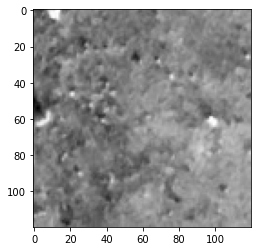

In [70]:
plt.imshow(DataSet[19000][0][0], cmap='gray')
plt.show()

In [69]:
model = torch.load('Model.pt')
model.eval()
with torch.no_grad():
    output = model(torch.unsqueeze(DataSet[19000][0], 0))
    # nope = criterion(output, 0)
    print(output)

tensor([[1.0000e+00, 4.1188e-32]])


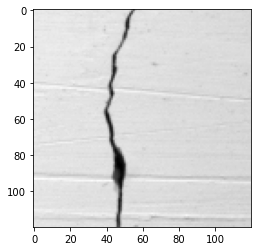

In [71]:
# Checking for the Image out of the DataSet
TestImg = cv2.imread('Images/crack_1.png', cv2.IMREAD_GRAYSCALE)
# Resizing
TestImgRe = cv2.resize(TestImg, (120, 120))
# Converting to Tensor
ImgTensor = torch.zeros((1, 120, 120))
ImgTensor[0] = torch.from_numpy(TestImgRe)
# Viewing the Image
plt.imshow(TestImgRe, cmap='gray')
plt.show()

In [72]:
model = torch.load('Model.pt')
model.eval()
with torch.no_grad():
    output = model(torch.unsqueeze(ImgTensor, 0))
    print(output)

tensor([[0., 1.]])
